In [20]:
library(httr)
library(jsonlite)
library(tidyverse)
library(patchwork)
library(anytime)
library(testthat)
git_stats <- function(repo_name){
    
    base_url <- "https://api.github.com/repos/"
    params <- gsub(" ", "", paste(repo_name,"/stats/contributors"))
    url <- gsub(" ", "", paste(base_url,params)) 
    res = GET(url)
    test_that("Input should be a valid repository name.", {
        expect_equal(res[['status_code']], 200)
    })
    if (res[['status_code']] != 200) {
     stop()}
    flush.console()
    data = fromJSON(rawToChar(res$content))
    
    loginname <- readline(prompt="Enter login name: ")
    author<-data$author
    
    if ((loginname %in%  author$login) != TRUE) {
     stop("This user login name doesn't exist.")}
    
    index_data<-which(author$login == loginname)
    data_weeks<-data$weeks
    current_user<-data_weeks[[index_data]]
    current_user$w<-anydate(current_user$w)
    
    
    
    adds_per_user <- function(current_user) {
    df_adds<-current_user%>%group_by(w)%>%summarise(adds=sum(a))%>%arrange(desc(w))
      
        if (length(df_adds) == 0) {
        stop("This user has no data.")}
        return(df_adds)
    }
    
    
    
    deletes_per_user <- function(current_user) {
    df_deletes<-current_user%>%group_by(w)%>%summarise(deletes=sum(d))%>%arrange(desc(w))
        if (length(df_deletes) == 0) {
        stop("This user has no data.")}
        
        return(df_deletes)
    }
    
    commits_per_user <- function(current_user) {
    df_commits<-current_user%>%group_by(w)%>%summarise(commits=sum(c))%>%arrange(desc(w))
        if (length(df_commits) == 0) {
        stop("This user has no data.")}
        
        return(df_commits)
    }
    
    
    
    
    everything_per_user <- function(current_user) {
          df_everything<-current_user%>%group_by(w)%>%summarise(commits=sum(c), additions=sum(a), deletions=sum(d))%>%arrange(desc(w))
           if (length(df_everything) == 0) {
          stop("This user has no data.")}
        
           return(df_everything)
            }
    adds_per_user_viz<-function(current_user)
    {
    options(repr.plot.width=16, repr.plot.height=8)
    p <- ggplot(adds_per_user(current_user), aes(x=w, y=adds)) +
    geom_line(color="green3", size=0.8) + 
    xlab("Year")+ylab("Adds") + theme_bw() + theme(axis.text=element_text(size=16, face="bold"),
                axis.title=element_text(size=19,face="bold")) 
    return(p)
    }
        
    deletes_per_user_viz<-function(current_user)
    {
    options(repr.plot.width=16, repr.plot.height=8)
    p <- ggplot(deletes_per_user(current_user), aes(x=w, y=deletes)) +
    geom_line(color="green3", size=0.8) + 
    xlab("Year")+ylab("Deletes") + theme_bw() + theme(axis.text=element_text(size=16, face="bold"),
                axis.title=element_text(size=19,face="bold")) 
    return(p)
    }
        
    commits_per_user_viz<-function(current_user)
    {
    options(repr.plot.width=16, repr.plot.height=8)
    p <- ggplot(commits_per_user(current_user), aes(x=w, y=commits)) +
    geom_line(color="green3", size=0.8) + 
    xlab("Year")+ylab("Commits") + theme_bw() + theme(axis.text=element_text(size=16, face="bold"),
                axis.title=element_text(size=19,face="bold")) 
    return(p)
    }
    everything_per_user_viz<-function(current_user)
    {
    options(repr.plot.width=16, repr.plot.height=8)
    pc <- ggplot(everything_per_user(current_user), aes(x=w, y=commits)) +
      geom_line(color="magenta3", size=0.8) + 
      xlab("Year")+ylab("Commits") + theme_bw() + theme(axis.text=element_text(size=16, face="bold"),
                axis.title=element_text(size=19,face="bold"))
    
    pd <- ggplot(deletes_per_user(current_user), aes(x=w, y=deletes)) +
      geom_line(color="royalblue3", size=0.8) + 
      xlab("Year")+ylab("Deletes") + theme_bw() + theme(axis.text=element_text(size=16, face="bold"),
                axis.title=element_text(size=19,face="bold"))    
    
    pa <- ggplot(adds_per_user(current_user), aes(x=w, y=adds)) +
      geom_line(color="green3", size=0.8) + 
      xlab("Year")+ylab("Adds") + theme_bw() + theme(axis.text=element_text(size=16, face="bold"),
                axis.title=element_text(size=19,face="bold"))     

    options(repr.plot.width=13, repr.plot.height=15)    
    pe <- (pa / pd / pc)

    return(pe)    
    }

    while(1){
    user_stats_choice <- readline(prompt="Enter which stats you are looking for the user(type from the following options - \n 1. Additions \n 2. Deletions \n 3. Commits \n 4.All \n 5. None): \n ")
    
    if(user_stats_choice  == "1"){
        df<-adds_per_user(current_user)
        df<-df%>%arrange(desc(adds))
        print("/n Here are the top dates with respect to adds")
        print(head(df))
        flush.console()
        
        user_viz_choice <- readline(prompt="\n Do you want to look at the timeseries visualization for this user? \n yes \n no: ")
        if(user_viz_choice  == "yes"){
            print(adds_per_user_viz(current_user))
        flush.console()
    }
    break;    
    }
    
    else if(user_stats_choice == "2"){
        df<-deletes_per_user(current_user)
        df<-df%>%arrange(desc(deletes))
        print("/n Here are the top dates with respect to deletes")
        print(head(df))
        flush.console()
        user_viz_choice <- readline(prompt="\n Do you want to look at the timeseries visualization for this user? \n yes \n no: \n")
        if(user_viz_choice  == "yes"){
            print(deletes_per_user_viz(current_user))
        flush.console()
    }
    break; 
    }
        
    else if(user_stats_choice == "3"){
        df<-commits_per_user(current_user)
        df<-df%>%arrange(desc(commits))
        print("/n Here are the top dates with respect to commits")
        print(head(df))
        flush.console()
        user_viz_choice <- readline(prompt="\n Do you want to look at the timeseries visualization for this user? \n yes \n no: \n")
        if(user_viz_choice  == "yes"){
            print(commits_per_user_viz(current_user))
        flush.console()
    }
    break; 
    }
    else if(user_stats_choice == "4"){
        df<-everything_per_user(current_user)
        df<-df%>%arrange(desc(commits))
        print("/n Here are the top dates with respect to commits")
        print(head(df))
        flush.console()
        user_viz_choice <- readline(prompt="\n Do you want to look at the timeseries visualization for this user? \n yes \n no: \n")
        if(user_viz_choice  == "yes"){
            print(everything_per_user_viz(current_user))
        flush.console()
    }
    break; 
    }
    else if(user_stats_choice == "5") {
        break; }
    else {
        print("\n Invalid Input \n")
        }
        }}


Test passed 


Enter login name:  87
Enter which stats you are looking for the user(type from the following options - 
 1. Additions 
 2. Deletions 
 3. Commits 
 4.All 
 5. None): 
  4


[1] "/n Here are the top dates with respect to commits"
# A tibble: 6 x 4
  w          commits additions deletions
  <date>       <int>     <int>     <int>
1 2011-09-10      10       139        61
2 2011-10-15       8       389       347
3 2012-09-08       6       103        52
4 2012-09-01       6        29        25
5 2011-10-22       6        96        26
6 2012-09-15       5       168       110



 Do you want to look at the timeseries visualization for this user? 
 yes 
 no: 
 yes


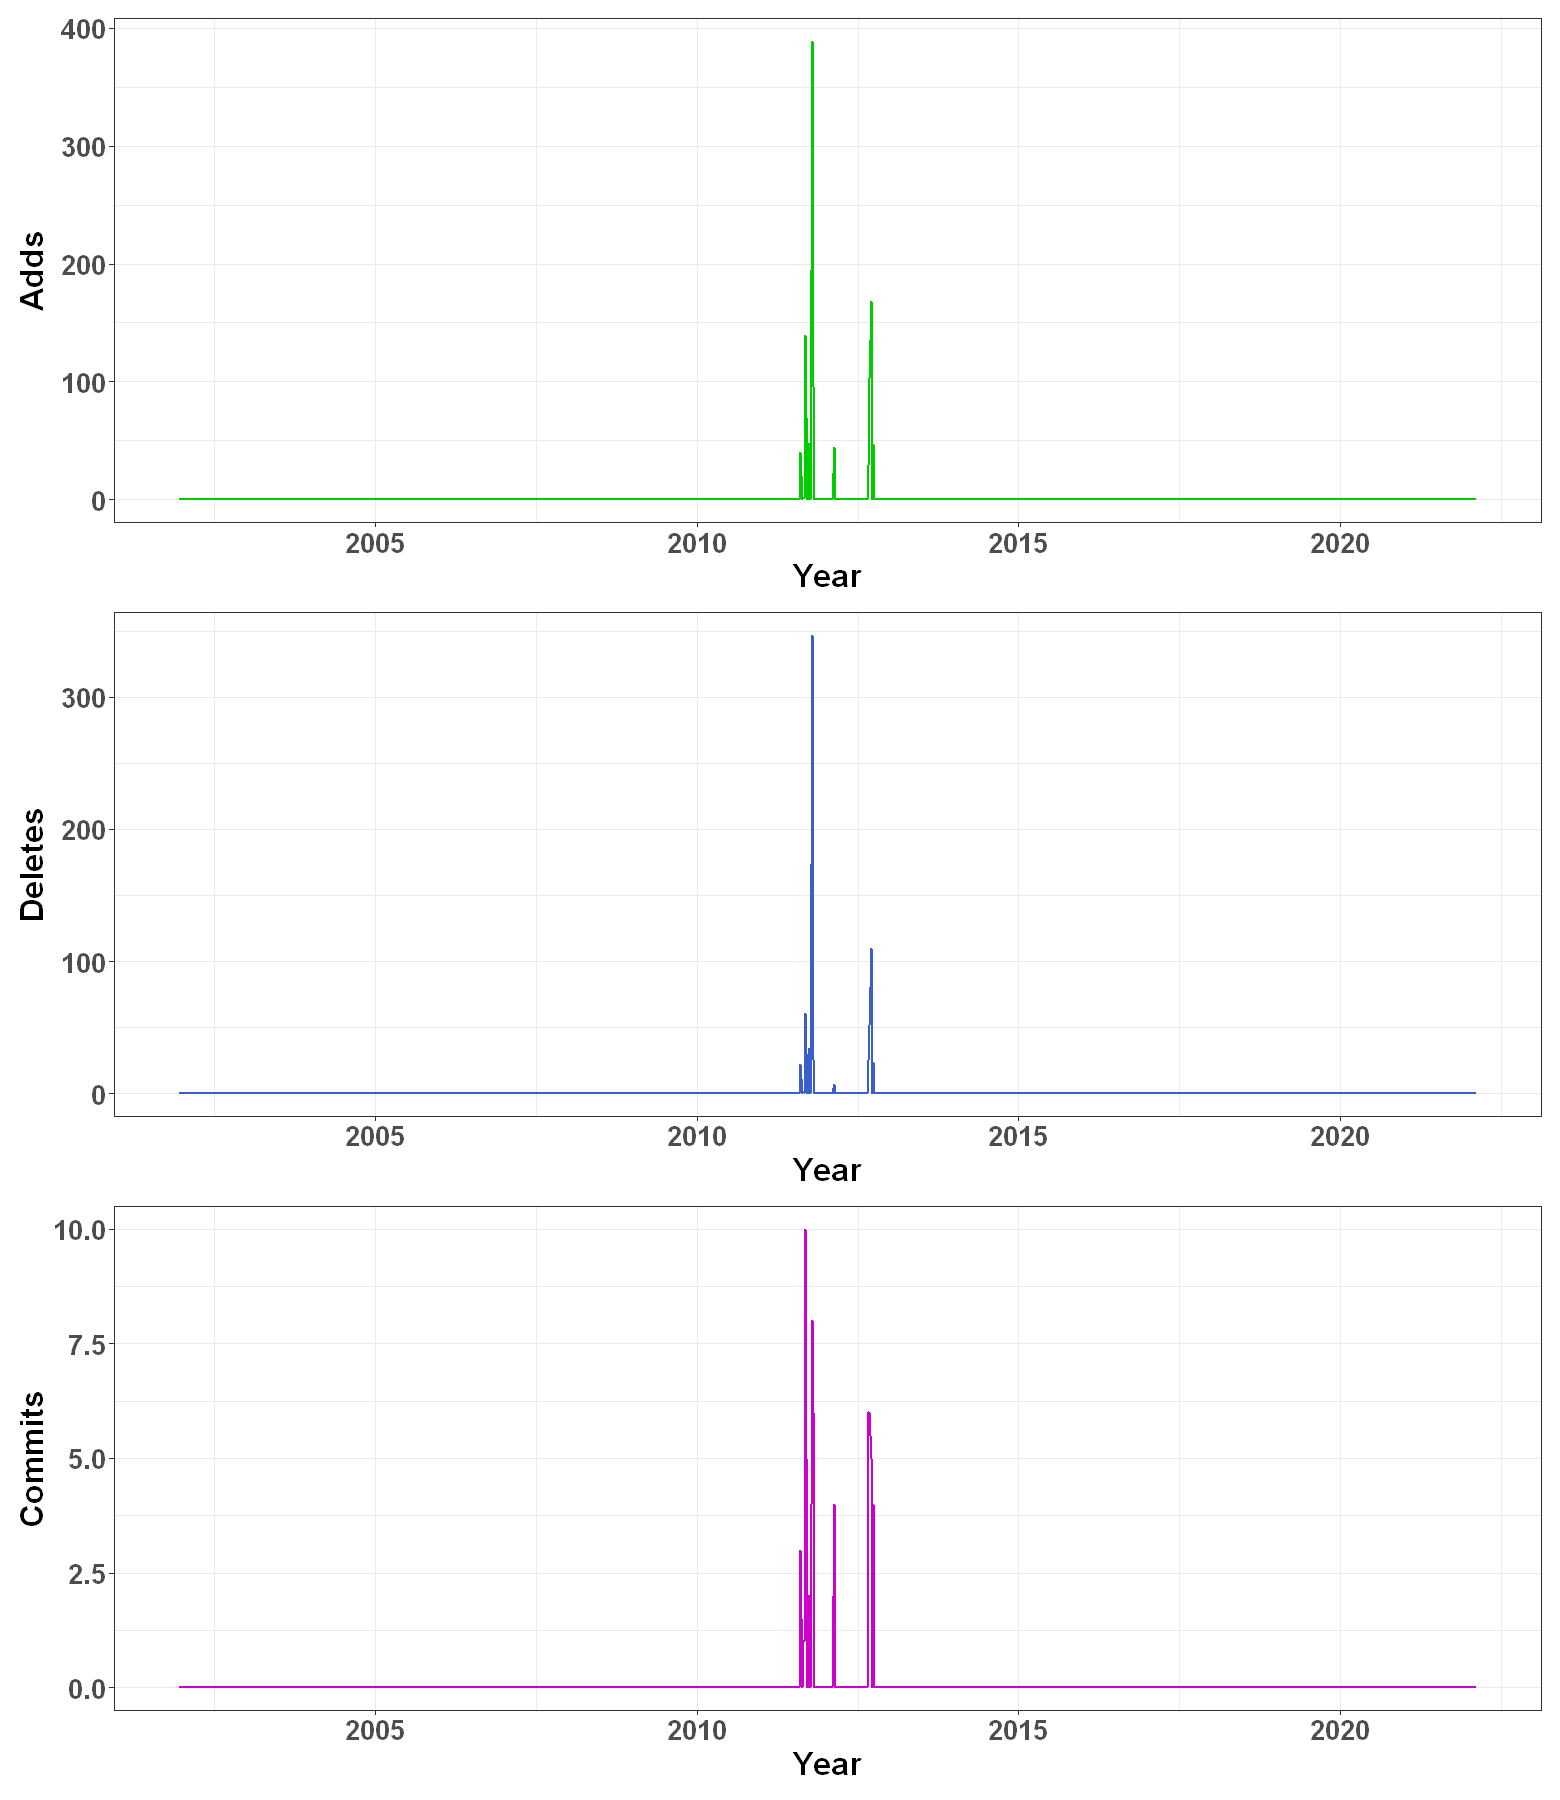

In [24]:
git_stats('numpy/numpy')